In [ ]:
# this is colab file for MEAM517 Project

Mount Github files to Google Drive

In [1]:
! rm -rf sample_data; curl -s https://raw.githubusercontent.com/DayongTong/MEAM517_Project_Git/main/sync_project.py > sync_project.py
files = ["spacecraft.py","simulation.py", "dynamic_constraints.py", "kinematic_constraints.py","plot_util.py"]

from sync_project import sync_project
sync_project(files, False)

Mounted at /content/drive


Install Drake

In [2]:
# install pydrake

!curl -s https://raw.githubusercontent.com/mposa/MEAM517/master/colab_drake_setup.py > colab_drake_setup.py
from colab_drake_setup import setup
setup()

<IPython.core.display.Javascript object>

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 11  205M   11 23.1M    0     0   483k      0  0:07:15  0:00:48  0:06:27  511k
curl: (56) OpenSSL SSL_read: SSL_ERROR_SYSCALL, errno 104


Import Packages

In [ ]:
from pydrake.all import eq, MathematicalProgram, Solve, Variable

import matplotlib.pyplot as plt
import numpy as np
import importlib

from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve, SolverType
from pydrake.trajectories import PiecewisePolynomial
from pydrake.solvers.snopt import SnoptSolver


In [ ]:
import kinematic_constraints
import dynamic_constraints
import plot_util
importlib.reload(plot_util)
importlib.reload(kinematic_constraints)
importlib.reload(dynamic_constraints)
from kinematic_constraints import (
    AddInitialConstraints,
    AddLandingConstraints
)
from dynamic_constraints import (
    AddCollocationConstraints,
    EvaluateDynamics
)
from plot_util import plot_util

In [ ]:
# set up constants

N = 20     # number of collocation points
n_x = 9
n_u = 3

# where we start, where we go, mass?, 
# start position
r_0 = 3474.8*1000                 #radius of Mars, in km
alpha_0 = -23.45*np.pi/180   #longitude degrees
beta_0 = -2.94*np.pi/180   #latitude degrees
Vx_0 = 0
Vy_0 = 0
Vz_0 = 0
m_0 = 15234                  #kg
phi_0 = 90*np.pi/180         #pitch degrees
psi_0 = 90*np.pi/180          #yaw degrees

# final position
r_N = 3474.8*1000                 #radius of Mars, in km
alpha_N = -23.45*np.pi/180   #radians
beta_N = -1.94*np.pi/180     #radians
Vx_N = 0
Vy_N = 0
Vz_N = 0
phi_N = 90*np.pi/180
psi_N = 0

# initial control input 
T_0 = 0
phidot_0 = 0
psidot_0 = 0

# final control input
T_N = 0
phidot_N = 0
psidot_N = 0

# constraint coefficients
r_min = 3474.8*1000
h_max = 30*1000
r_max = 3474.8*1000 + h_max     #h_max km above Mars surface
phi_min = -90*np.pi/180    #degree
phi_max = 90*np.pi/180     #degree
psi_min = -180*np.pi/180   #degree
psi_max = 180*np.pi/180    #degree
phidot_min = -8*np.pi/180  #deg/sec
phidot_max = 8*np.pi/180   #deg/sec
psidot_min = -8*np.pi/180  #deg/sec
psidot_max = 8*np.pi/180   #deg/sec
T_min = 0                  #Newton
T_max = 43148              #Newton

initial_state = np.array([r_0,alpha_0,beta_0,Vx_0,Vy_0,Vz_0,m_0,phi_0,psi_0])
final_state = np.array([r_N,alpha_N,beta_N,Vx_N,Vy_N,Vz_N,phi_N,psi_N])
input_limit = np.array([[T_min,phidot_min,psidot_min],[T_max,phidot_max,psidot_max]])
initial_input = np.array([T_0,phidot_0,psidot_0])
final_input = np.array([T_N,phidot_N,psidot_N])


# m = 8321.09        #kg
g = 3.711          #m/s^2
Isp = 302.39       #s (effective specific impulse of the lander, used in mdot equation)


In [ ]:
# Initialize Mathematical Program and Add Variables

prog = MathematicalProgram()
x = np.zeros((N,n_x),dtype="object")
u = np.zeros((N,n_u),dtype="object")
dt = np.zeros((1,), dtype="object")

for i in range(N):
    x[i] = prog.NewContinuousVariables(n_x,"x_" + str(i))
    u[i] = prog.NewContinuousVariables(n_u,"u_" + str(i))
dt = prog.NewContinuousVariables(1,"dt") 

t0 = 0.0

In [ ]:
# Add linear cost
gz = 0
for i in range(N):
    gz += u[i,0]*u[i,0]
# gz = -x[N-1,6] + np.sum(u[:,0])
# gz += -x[N-1, 6]
prog.AddQuadraticCost(gz)

In [ ]:
 # Add dynamic constraint
AddCollocationConstraints(prog, N, x, u, dt)

In [ ]:
# TODO: Add kinematic initial and final(landing) constraint
AddInitialConstraints(prog, N, x, u, initial_state, initial_input)
AddLandingConstraints(prog, N, x, u, final_state, final_input)

In [ ]:
# TODO: Add input/state limitation as bounding box constraints: NEED CHECK

# height limit: 0 <= h <= hmax
prog.AddBoundingBoxConstraint(r_min, r_max, x[:,0])

# mass upper limit
# prog.AddBoundingBoxConstraint(0.1, m_0, x[:,6])
for i in range(N-1):
  prog.AddLinearConstraint(x[i+1, 6] <= x[i, 6])

# angular position input limit
prog.AddBoundingBoxConstraint(phi_min, phi_max, x[:,7]) #infeasible constraint
prog.AddBoundingBoxConstraint(psi_min, psi_max, x[:,8])

# thrust input limit
prog.AddBoundingBoxConstraint(T_min, T_max, u[:,0])# change constraint
# thrust input limit
# f1 = (u[:,0] - T_min)*(0.65*T_max - u[:,0])
# f2 = (u[:,0] - T_max)*(T_max - u[:,0])
# F = f1 + f2 + np.sqrt(f1**2 + f2**2)
# for i in range(N):
#   prog.AddConstraint(F[i]>=0)


# omega angular velocity state limits
prog.AddBoundingBoxConstraint(phidot_min, phidot_max, u[:,1])
prog.AddBoundingBoxConstraint(psidot_min, psidot_max, u[:,2])

In [ ]:
# Set up solver initial guess

# state initial guess
xinit = np.zeros((N,n_x))

# altitude initial guess
a1 = np.linspace(r_0,r_0+6,N-N//2)
a2 = np.linspace(r_0+5,r_0,N//2)
xinit[:,0] = np.concatenate((a1,a2),axis=0)

# longitude initial guess
a1 = np.linspace(alpha_0,-23.47*np.pi/180,N-N//2)
a2 = np.linspace(-23.46*np.pi/180,alpha_N,N//2)
xinit[:,1] = np.concatenate((a1,a2),axis=0)

# latitude initial guess
xinit[:,2] = np.linspace(beta_0,beta_N,N)

# velocity Vx
a1 = np.linspace(Vx_0,100,N//5)
a2 = np.linspace(100,-100,N-2*N//5)
a3 = np.linspace(-100,Vx_N,N//5)
xinit[:,3] = np.concatenate((a1,a2,a3),axis=0)

# velocity Vy no need to do anything, all zeros is a good guess

# velocity Vz
a1 = np.linspace(Vz_0,150,N-N//2)
a2 = np.linspace(140,Vz_N,N//2)
xinit[:,5] = np.concatenate((a1,a2),axis=0)
# mass
xinit[:,6] = np.full(N,m_0)

# pitch phi Need Halp
xinit[:,7] = np.full(N,phi_0)

# yaw psi
xinit[:,8] = np.full(N,psi_0)

# input initial guess
uinit = np.zeros((N,n_u))
for i in range(n_u):
    uinit[:,i] = np.random.uniform(input_limit[0,i],input_limit[1,i],N)


# set up initial dt time guess
tinit = 0.5

prog.SetInitialGuess(u,uinit)
prog.SetInitialGuess(x,xinit)
prog.SetInitialGuess(dt, [tinit])

In [ ]:
# set up solver
solver = SnoptSolver()
prog.SetSolverOption(SolverType.kSnopt, "Iterations limit", 1000000)
result = solver.Solve(prog)
print(result.get_solution_result())
# get solution of states and inputs from solver result
x_sol = result.GetSolution(x)
u_sol = result.GetSolution(u)
t_sol = result.GetSolution(dt)
timesteps = np.linspace(t0, t_sol*N, N)
xdot_sol = np.zeros(x_sol.shape)
for i in range(N):
    xdot_sol[i] = EvaluateDynamics(x_sol[i],u_sol[i])

# create trajectory by interpolating between collocation points using piecewise polynomial
x_traj = PiecewisePolynomial.CubicHermite(timesteps,x_sol.T,xdot_sol.T)
u_traj = PiecewisePolynomial.FirstOrderHold(timesteps,u_sol.T)

SolutionResult.kUnknownError


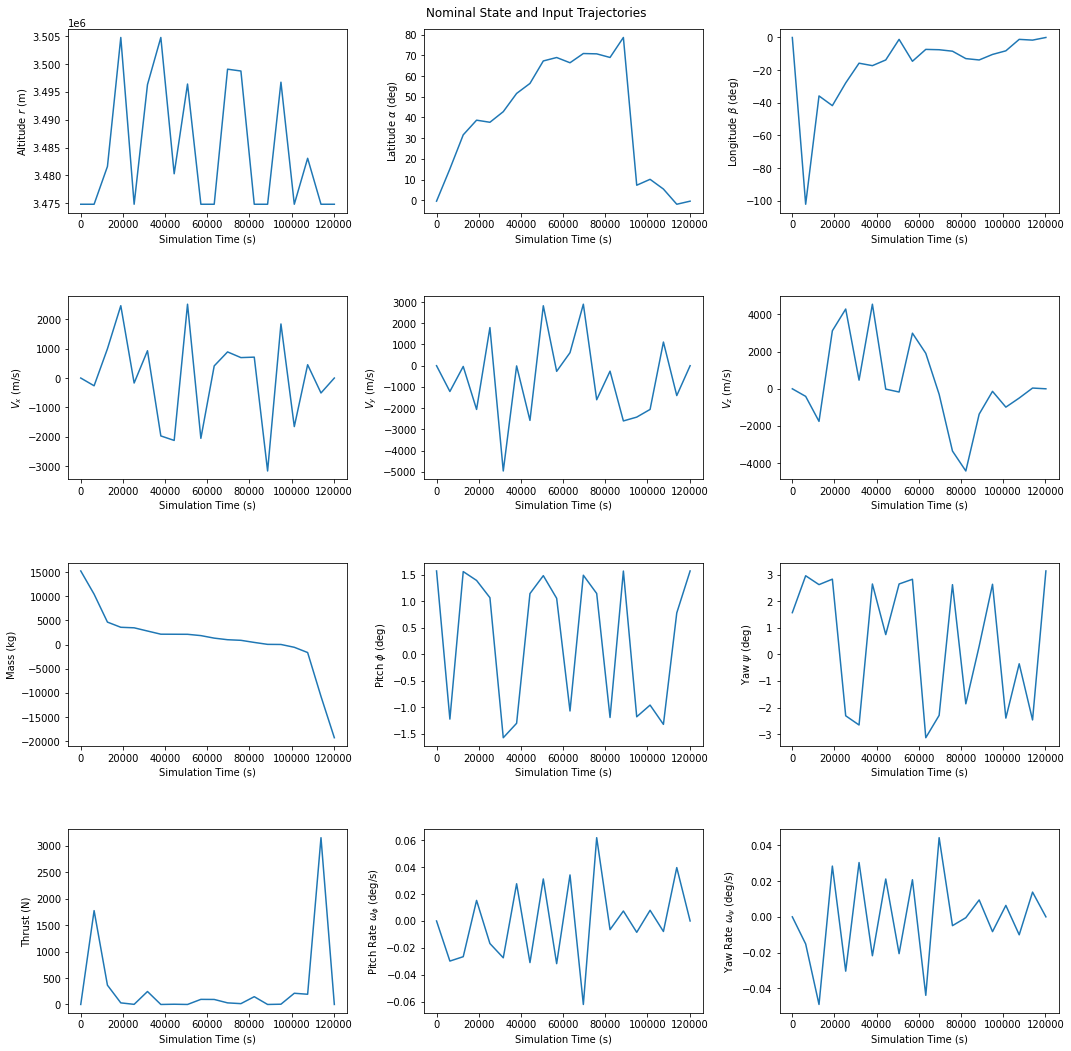

In [ ]:
plot_util(timesteps,x_sol,u_sol,n_x)

In [ ]:
adef plot_util(timesteps, x_sol, u_sol):
  fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
  fig.subplots_adjust(hspace=10)
  fig.suptitle('Nominal State and Input Trajectories')
  labels = ['Altitude $r$ (m)', r'Latitude $\alpha$ (deg)', r'Longitude $\beta$ (deg)',
            '$V_x$ (m/s)', '$V_y$ (m/s)', '$V_z$ (m/s)',
            'Mass (kg)', r'Pitch $\phi$ (deg)', r'Yaw $\psi$ (deg)',
            'Thrust (N)', r'Pitch Rate $\omega_{\phi}$ (deg/s)', r'Yaw Rate $\omega_{\psi}$ (deg/s)']

  for idx, ax in enumerate(axes.flatten()):
    if idx < n_x:
      ax.plot(timesteps, x_sol[:,idx])
    else:
      ax.plot(timesteps, u_sol[:,idx % n_x])
    ax.set(ylabel = labels[idx])
    ax.set(xlabel = "Simulation Time (s)")

  plt.tight_layout()

In [ ]:
print("Total mass lost:", xinit[N-1, 6] - x_sol[N-1, 6], "kg")

Total mass lost: 10041.16296725986 kg


In [ ]:
import spacecraft
importlib.reload(spacecraft)
from spacecraft import Spacecraft

import simulation
importlib.reload(simulation)
from simulation import simulate_spacecraft

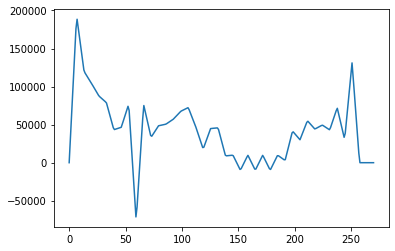

In [ ]:
temp = np.zeros(270)
for i in range(270):
    temp[i] = u_traj.value(i)[0].item()
plt.plot(np.linspace(0,270,270),temp)

In [ ]:
# TODO: create LQR to follow the trajectory (use HW2)

R = np.eye(3)
Q = np.eye(9)
Qf = Q

spacecraft = Spacecraft(Q,R,Qf,t_sol.item()*N,x_traj,u_traj)
xsim,usim,tsim = simulate_spacecraft(x_traj.value(0).flatten(),u_traj.value(0).flatten(),t_sol.item()*N,spacecraft)


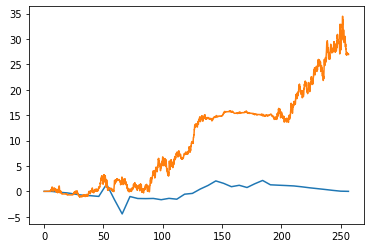

In [ ]:
plt.plot(timesteps,x_sol[:,4])
plt.plot(tsim,xsim[:,4])

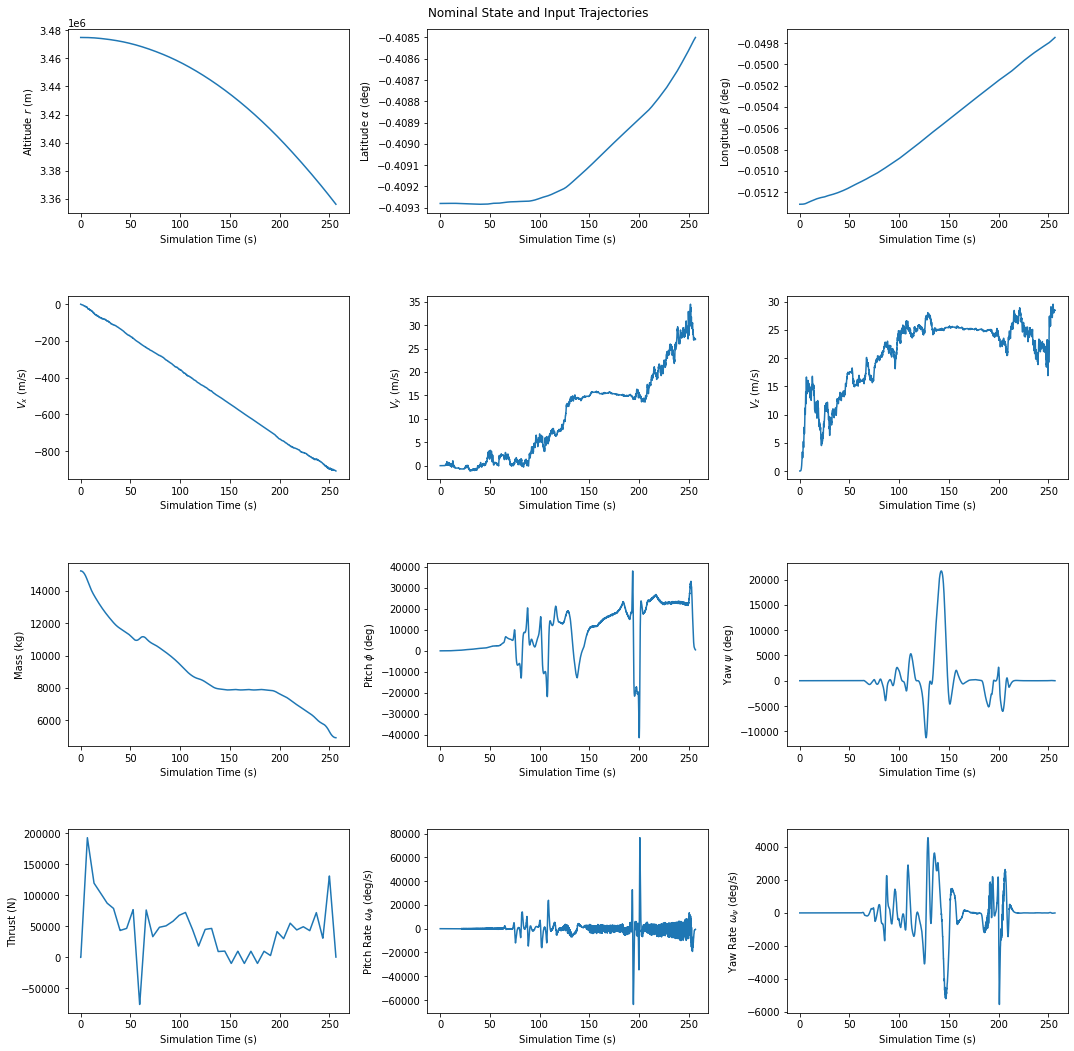

In [ ]:
# TODO: simulate and animate path, create disturbance in simulation
plot_util(tsim,xsim,usim,n_x)

In [ ]:
def eval_dynamics(x, u):
    r = x[0]
    alpha = x[1]
    beta = x[2]
    Vx = x[3]
    Vy = x[4]
    Vz = x[5]
    m = x[6]
    phi = x[7]
    psi = x[8]

    g_m = 3.71 # Mars
    I_sp = 302.39

    rdot = Vx
    alphadot = Vy/(r*np.cos(beta))
    betadot = Vz/r

    T = u[0]
    omega_phi = u[1]
    omega_psi = u[2]

    mdot = -T/(I_sp*g_m)

    Vxdot = T*np.sin(phi)/m - g_m + (Vy**2 + Vz**2)/r
    Vydot = T*np.cos(phi)*np.cos(psi)/m - (Vx*Vy)/r + (Vy*Vz*np.tan(beta))/r
    Vzdot = T*np.cos(phi)*np.sin(psi)/m - (Vx*Vz)/r - (Vy**2*np.tan(beta))/r

    xdot  = np.array([rdot, alphadot, betadot,
                        Vxdot, Vydot, Vzdot, 
                        mdot, omega_phi, omega_psi])
    return np.reshape(xdot,(9,))
# print(xdot)
# print(eval_dynamics(x_sol, u_sol))
print(x_sol.shape)
err = np.zeros((20,9))
xdot_traj = np.zeros((20,9))
xdot = np.zeros((20,9))
# xdot = eval_dynamics(x_sol, u_sol)
for i in range(20):
    xdot[i,:] = (eval_dynamics(x_sol[i,:],u_sol[i,:]))
    xdot_traj[i,:] = (eval_dynamics(x_traj.value(timesteps[i]),u_traj.value(timesteps[i])))
    err[i,:] = np.abs(xdot[i,:] - xdot_traj[i,:])

# plt.plot(timesteps, xdot[0])


(20, 9)


(0.0, 100.0)

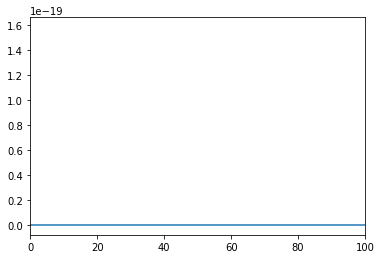

In [ ]:
plt.plot(timesteps,err[:,8])
plt.xlim(0,100)

In [ ]:
def compute_A(x, u):
    r = x[0].item()
    alpha = x[1].item()
    beta = x[2].item()
    Vx = x[3].item()
    Vy = x[4].item()
    Vz = x[5].item()
    m = x[6].item()
    phi = x[7].item()
    psi = x[8].item()

    T = u[0].item()
    omega_phi = u[1].item()
    omega_psi = u[2].item()

    A = np.array([  [0,0,0,1,0,0,0,0,0],
                    [-Vy/(r**2*cos(beta)), 				0,	Vy*sin(beta)/(r*cos(beta)**2), 	0, 		1/(r*cos(beta)), 		0, 				0, 							0, 						0],
                    [-Vz/r**2, 							0, 	0, 								0, 		0, 						1/r, 			0, 							0, 						0],
                    [-(Vy**2+Vz**2)/r**2, 				0, 	0, 								0, 		2*Vy/r, 				2*Vz/r, 		-T*sin(phi)/m**2, 			T*cos(phi)/m, 			0],
                    [Vx*Vy/r**2-Vy*Vz*tan(beta)/r**2,	0,	Vy*Vz*(1+tan(beta)**2)/r, 		-Vy/r,	-Vx/r+Vz*tan(beta)/r,	Vy*tan(beta)/r,	-T*cos(phi)*cos(psi)/m**2,	-T*sin(phi)*cos(psi)/m,	-T*cos(phi)*sin(psi)/m],
                    [Vx*Vz/r**2+Vy**2*tan(beta)/r**2, 	0, 	-Vy**2*(1+tan(beta)**2)/r, 		-Vz/r, 	-2*Vy*tan(beta)/r, 		-Vx/r, 			-T*cos(phi)*sin(psi)/m**2,	-T*sin(phi)*sin(psi)/m,	T*cos(phi)*cos(psi)/m],
                    [0, 0, 0, 0, 0, 0, 0, 0,0],
                    [0, 0, 0, 0, 0, 0, 0, 0,0],
                    [0, 0, 0, 0, 0, 0, 0, 0,0]])
    return A

def compute_B(x, u):
    r = x[0].item()
    alpha = x[1].item()
    beta = x[2].item()
    Vx = x[3].item()
    Vy = x[4].item()
    Vz = x[5].item()
    m = x[6].item()
    phi = x[7].item()
    psi = x[8].item()

    T = u[0].item()
    omega_phi = u[1].item()
    omega_psi = u[2].item()

    B = np.array([  [0, 0, 0],
                    [0, 0, 0],
                    [0, 0, 0],
                    [sin(phi)/m, 0, 0],
                    [cos(phi)*cos(psi)/m, 0, 0],
                    [cos(phi)*sin(psi)/m, 0, 0],
                    [-1/(self.Isp*self.g), 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]])
    return B

def compute_G(x, u):
    #TODO: compute G

def ell_w(x, u, D, E_1, Q_l, R_l, Ql_n, Q, R, N):
    ell = 0
    for i in range(N-1):
        A[i] = compute_A(x, u)
        B[i] = compute_B(x, u)
        G[i] = compute_G(x, u)

    K = #LQR(A, B, Q, R)
    H[0] = np.zeros()
    E[0] = E_1
    
    for i in range(N-1):
        mat = (Q_l + K[i].T @ R_l @ K[i]) @ E[i]
        ell += mat.trace()
        E[i+1] = (A[i] - B[i] @ K[i]) @ E[i] @ (A[i] - B[i] @ K[i]).T +  (A[i] - B[i] @ K[i]) @ H[i] @ G[i].T + \
                G[i] @ H[i] @  (A[i] - B[i] @ K[i]).T + G[i] @ D @ G[i].T
        H[i+1] =  (A[i] - B[i] @ K[i]) @ H[i] + G[i] @ D

    mat2 = Ql_n @ E[N]
    ell += mat2.trace()
    return ell

